In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [59]:
# Path to your Excel file
file_path = 'EIOPA_RFR_20240229_Term_Structures.xlsx'

# Read Excel file
df = pd.read_excel(file_path, "RFR_spot_no_VA", usecols="S", )
df = df[9:]
df = df.rename(columns={'Unnamed: 18': 'EIOPA IT without VA, FEB'})
rt = np.array(df).T
rt = np.array(rt, np.float64)

In [60]:
def simulate_gbm_vec(F0, r, sigma, dt, N, m_MC):
    # Generate N samples from a GBM with risk-free rate r and volatility sigma
    # r and sigma are assumed to be annualized
    # dt is the time step
    # S0 is the initial value of the process
    S = np.zeros((m_MC, N))
    S[:, 0] = np.full(m_MC, F0)
    for t in range(1, N):
        # Generate m_MC samples of random normal variables
        z = np.random.normal(size=m_MC)
        # Update the stock price for all iterations simultaneously
        S[:, t] = S[:, t - 1] * np.exp((r[t] - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return S

In [61]:
# Parameters
m_MC = 100 # Number of simulations
T = 50 # Time horizon in years
N = 50 # Number of time steps (daily frequency)
dt = T / N # Time step
F0 = 100000 # Initial value of the fund
sigma_equity = 0.20 # Volatility for equity
sigma_property = 0.10 # Volatility for property
rt = rt[0, :N] # Time-varying risk-free rate
PR_weight = 0.2 # Weight of PR in the portfolio
EQ_weight = 0.8 # Weight of EQ in the portfolio
RFR = 0.03
T = 50 
rd_rate = 0.022
comm_rate = 0.014
inflation_rate = 0.02

In [62]:
# Simulate equity and property paths
EQt= simulate_gbm_vec(F0, rt, sigma_equity, dt, N, m_MC)
PRt = simulate_gbm_vec(F0, rt, sigma_property, dt, N, m_MC)

# Calculate the fund value at each time step
fund_value = EQ_weight * EQt + PR_weight * PRt
F = np.squeeze(fund_value)

(50, 100)(50, 100)


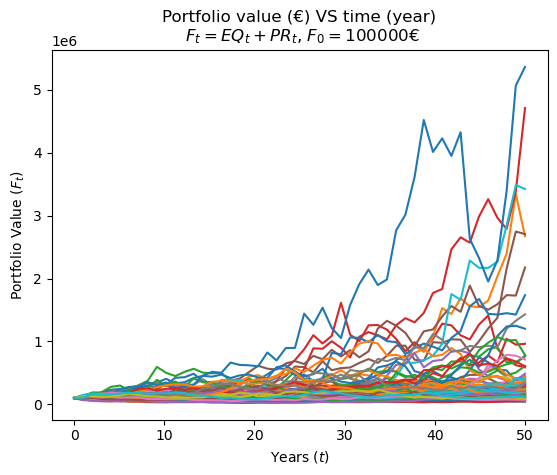

In [63]:
# Define time interval correctly
time = np.linspace(0,T,N)
# Require numpy array that is the same shape as F
tt = np.full(shape=(m_MC,N), fill_value=time).T
# Check that the dimensions are OK for the plot
print(str(tt.shape) + str(fund_value.T.shape))

plt.plot(tt, fund_value.T);
plt.xlabel("Years $(t)$")
plt.ylabel("Portfolio Value $(F_t)$")
plt.title("Portfolio value (€) VS time (year)\n $F_t = EQ_t + PR_t$, $F_0 = 100000€$")
plt.show()

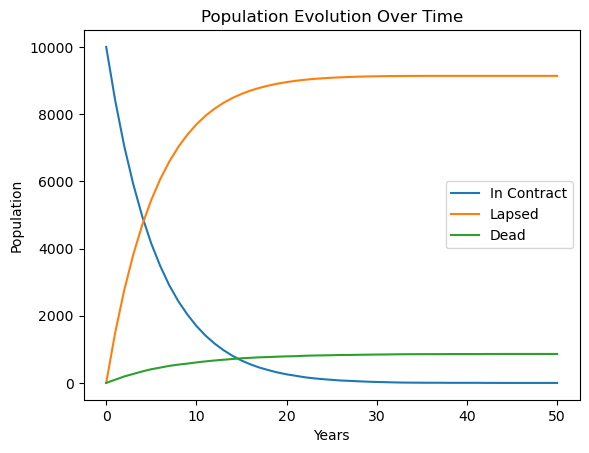

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
initial_population = 10000  # Initial population size
lapse_rate = 0.15  # Annual lapse rate
years = 50  # Number of years to simulate

# Life table (example)
life_table = np.array([
    0.0102, 0.0107, 0.0112, 0.0117, 0.0122,  # Age 60-64
    0.0127, 0.0133, 0.0140, 0.0147, 0.0154,  # Age 65-69
    0.0162, 0.0170, 0.0180, 0.0190, 0.0202,  # Age 70-74
    0.0215, 0.0231, 0.0249, 0.0269, 0.0290,  # Age 75-79
    0.0314, 0.0342, 0.0373, 0.0407, 0.0446,  # Age 80-84
    0.0489, 0.0537, 0.0590, 0.0648, 0.0711,  # Age 85-89
    0.0781, 0.0857, 0.0938, 0.1028, 0.1126,  # Age 90-94
    0.1232, 0.1348, 0.1473, 0.1608, 0.1752,  # Age 95-99
    0.1906, 0.2068, 0.2239, 0.2419, 0.2607,  # Age 100-104
    0.2806, 0.3008, 0.3335, 0.3550, 0.3800   # Age 105-109
]) 

# Initialize lists to store population data
population_in_contract = [initial_population]
population_lapsed = [0]
population_dead = [0]

# Simulate population evolution over 50 years
for year in range(1, years + 1):
    # Calculate number of deaths
    # deaths = np.random.binomial(population_in_contract[-1], life_table[min(year, max(life_table.keys()))])
    deaths = np.random.binomial(population_in_contract[-1], life_table[year - 1])

    # Calculate number of lapses
    lapses = int(population_in_contract[-1] * lapse_rate)

    # Update population
    population_in_contract.append(max(0, population_in_contract[-1] - deaths - lapses))
    population_lapsed.append(population_lapsed[-1] + lapses)
    population_dead.append(population_dead[-1] + deaths)

# Plot population evolution
years_range = range(years + 1)
plt.plot(years_range, population_in_contract, label='In Contract')
plt.plot(years_range, population_lapsed, label='Lapsed')
plt.plot(years_range, population_dead, label='Dead')
plt.xlabel('Years')
plt.ylabel('Population')
plt.title('Population Evolution Over Time')
plt.legend()
plt.show()


In [65]:
def forward_diff(arr):
    """
    Compute the forward difference of an array.
    Example :
    arr = [1, 3, 6, 10, 15]
    result = forward_diff(arr)
    print("Forward difference:", result)
    [2, 3, 4, 5]
    """
    arr = np.asarray(arr)  # Convert input to NumPy array
    forward_diff = arr[1:] - arr[:-1]  # Compute forward difference
    return forward_diff

def lapse(array_of_diff, F, discount_factors, T):
    lapses = np.zeros(T)
    for t in range(T):
        lapses[t] = discount_factors[t] * array_of_diff[t] * (F[t] - 20)
    return lapses

def death(array_of_diff, F, discount_factors, T):
    deaths = np.zeros(T)
    for t in range(T):
        deaths[t] = discount_factors[t] * array_of_diff[t] * np.maximum(F[t], 100000)
    return deaths

def regular_deduction(array_of_alive, F, rd_rate, discount_factors, T):
    r_deductions = np.zeros(T)
    for t in range(T):
        r_deductions[t] = discount_factors[t] * array_of_alive[t] * rd_rate * (F[t] - 20)
    return r_deductions

def COMM(array_of_alive, F, comm_rate, discount_factors, T):
    comms = np.zeros(T)
    for t in range(T):
        comms[t] = discount_factors[t] * array_of_alive[t] * comm_rate * F[t]
    return comms

def expense(array_of_alive, inflation_rate, discount_factors, T):
    expenses = np.zeros(T)
    base_expenses = np.array([50 * (1 + inflation_rate) ** i for i in range(T)])
    for t in range(T):
        expenses[t] = discount_factors[t] * array_of_alive[t] * base_expenses[t] 
    return expenses

def liabilities_through_t(lapses, deaths, r_deductions, comms, expenses):
    liabilities = lapses + deaths - r_deductions + comms + expenses
    return liabilities

def discount_factor(RFR, T):
    v = 1 / (1 + RFR)
    discount_factors = np.array([v ** i for i in range(T)])
    return discount_factors

def RUN(population_in_contract, population_lapsed, population_dead, RFR, T, F, rd_rate, comm_rate, inflation_rate):
    discount_factors = discount_factor(RFR, T)

    lapse_diff = forward_diff(population_lapsed)
    lapses = lapse(lapse_diff, F, discount_factors, T)

    death_diff = forward_diff(population_dead)
    deaths = death(death_diff, F, discount_factors, T)

    r_deductions = regular_deduction(population_in_contract, F, rd_rate, discount_factors, T)

    comms = COMM(population_in_contract, F, comm_rate, discount_factors, T)

    expenses = expense(population_in_contract, inflation_rate, discount_factors, T)

    liabilities = liabilities_through_t(lapses, deaths, r_deductions, comms, expenses)
    return liabilities

In [66]:
def RUN_MC(m_MC, population_in_contract, population_lapsed, population_dead, RFR, T, rd_rate, comm_rate, inflation_rate, F0, rt, sigma_equity, dt, N):
    # Simulate equity and property paths
    EQt= simulate_gbm_vec(F0, rt, sigma_equity, dt, N, m_MC)
    PRt = simulate_gbm_vec(F0, rt, sigma_property, dt, N, m_MC)
    # Calculate the fund value at each time step
    F = EQ_weight * EQt + PR_weight * PRt

    MC = np.zeros(F.shape)

    for sim in range(F.shape[0]):
        FF = F[sim, :]
        MC[sim, :] = RUN(population_in_contract, population_lapsed, population_dead, RFR, T, FF, rd_rate, comm_rate, inflation_rate)
    
    BOF = N * F - MC
    
    return MC, BOF

In [67]:
MC_TOT, BOF = RUN_MC(m_MC, population_in_contract, population_lapsed, population_dead, RFR, T, rd_rate, comm_rate, inflation_rate, F0, rt, sigma_equity, dt, N)
MC_TOT.shape, BOF.shape

((100, 50), (100, 50))

(50, 100)(50, 100)


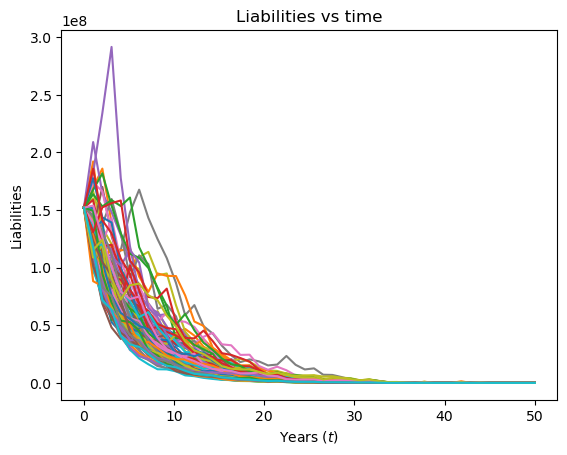

In [68]:
# Define time interval correctly
time = np.linspace(0,T,N)
# Require numpy array that is the same shape as F
tt = np.full(shape=(m_MC,N), fill_value=time).T
# Check that the dimensions are OK for the plot
print(str(tt.shape) + str(MC_TOT.T.shape))

plt.plot(tt, MC_TOT.T);
plt.xlabel("Years $(t)$")
plt.ylabel("Liabilities")
plt.title("Liabilities vs time")
plt.show()

(50, 100)(50, 100)


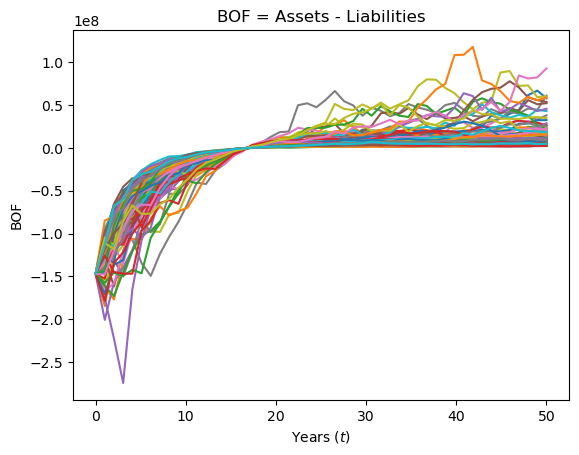

In [69]:
# Define time interval correctly
time = np.linspace(0,T,N)
# Require numpy array that is the same shape as F
tt = np.full(shape=(m_MC,N), fill_value=time).T
# Check that the dimensions are OK for the plot
print(str(tt.shape) + str(BOF.T.shape))

plt.plot(tt, BOF.T);
plt.xlabel("Years $(t)$")
plt.ylabel("BOF")
plt.title("BOF = Assets - Liabilities")
plt.show()

In [70]:
def build_coefficient_array(arr):
    n = len(arr)
    coefficient_array = [0] * n

    for i in range(n):
        for j in range(n - i):
            coefficient_array[i] += arr[n - j - 1]

    return coefficient_array

# Example usage:
arr = [1, 2, 3, 4, 5]
result = build_coefficient_array(arr)
print(result)

[15, 14, 12, 9, 5]


In [71]:
bof = BOF[0]
aa = build_coefficient_array(bof)

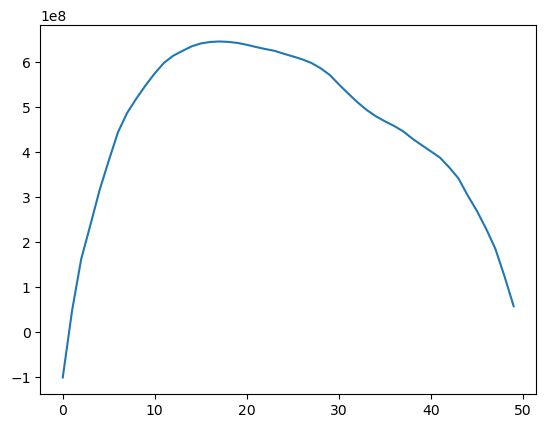

In [72]:
plt.plot(aa);